#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
path = '/content/drive/MyDrive/mp_06/'

### **(2) 라이브러리 설치 및 불러오기**

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Input
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [57]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [58]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [59]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [60]:
# 보간법으로 결측치 제거
oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
# 맨 앞 결측치 채우기
oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='bfill')

from IPython.display import display
list = ['oil_price','orders','sales','products','stores']

for i in list :
  print('--------------------------------------------------------------------------------------------------')
  print(i, '테이블')
  display(eval(i).head(5))
  print(eval(i).shape)

--------------------------------------------------------------------------------------------------
oil_price 테이블


,Date,WTI_Price
0,2014-01-01,95.14
1,2014-01-02,95.14
2,2014-01-03,93.66
3,2014-01-06,93.12
4,2014-01-07,93.31


(825, 2)
--------------------------------------------------------------------------------------------------
orders 테이블


,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875
3,2014-01-02,2,2122
4,2014-01-02,3,3350


(57558, 3)
--------------------------------------------------------------------------------------------------
sales 테이블


,Date,Store_ID,Qty,Product_ID
0,2014-01-01,1,0.0,3
1,2014-01-01,1,0.0,5
2,2014-01-01,1,0.0,7
3,2014-01-01,1,0.0,8
4,2014-01-01,1,0.0,10


(934275, 4)
--------------------------------------------------------------------------------------------------
products 테이블


,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23
3,15,HK002,Kitchen,Household Goods,2,41
4,32,GS001,Seafood,Grocery,3,34


(16, 6)
--------------------------------------------------------------------------------------------------
stores 테이블


,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4
3,4,Saint Paul,\tMinnesota,4
4,5,Oklahoma City,Oklahoma,4


(54, 4)


In [61]:
#Saint Paul 뽑기(18개 매장)
stores_minnesota = stores[stores['City'] == 'Saint Paul']
stores_minnesota

,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4
3,4,Saint Paul,\tMinnesota,4
5,6,Saint Paul,\tMinnesota,4
6,7,Saint Paul,\tMinnesota,4
7,8,Saint Paul,\tMinnesota,4
8,9,Saint Paul,\tMinnesota,2
9,10,Saint Paul,\tMinnesota,3
16,17,Saint Paul,\tMinnesota,3


## **(1) 상품 : 3 - Beverage**

In [70]:
df = sales.merge(products, on = 'Product_ID', how = 'left')
df = df.merge(stores, on = 'Store_ID', how = 'left')
df = df.merge(oil_price, on = 'Date', how = 'left')
df = df.merge(orders, on = ['Date', 'Store_ID'], how = 'left')

In [71]:
df = df.loc[df['Store_ID'] == 44]
df = df.loc[df['Product_ID'] == 3]

df1 = df
df1['weekday'] = df1['Date'].dt.weekday
df1['month'] = df['Date'].dt.month
df1['year'] = df1['Date'].dt.year
df1['y'] = df1['Qty'].shift(-2)
df1.drop(['Date'], axis=1, inplace=True)

df1 = df1[['weekday', 'Qty', 'CustomerCount', 'year', 'month', 'y']]

df1.drop(df1.loc[df1['Qty'] == 0].index, inplace=True)
df1.dropna(inplace=True)
df1.head()

,weekday,Qty,CustomerCount,year,month,y
1456,3,9853.0,4422.0,2014,1,15153.0
2267,4,8647.0,4167.0,2014,1,15606.0
3078,5,15153.0,5341.0,2014,1,7900.0
3889,6,15606.0,5123.0,2014,1,7188.0
4700,0,7900.0,3917.0,2014,1,8800.0


In [64]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1144 entries, 1456 to 932487
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   weekday        1144 non-null   int32  
 1   Qty            1144 non-null   float64
 2   CustomerCount  1144 non-null   float64
 3   year           1144 non-null   int32  
 4   month          1144 non-null   int32  
 5   y              1144 non-null   float64
dtypes: float64(3), int32(3)
memory usage: 49.2 KB


## **(2) 상품 : 12 - Milk**

In [65]:
# 44번 store, 12번 제품 df 생성
sales_44_12 = sales[(sales['Product_ID'] == 12) & (sales['Store_ID'] == 44)]

# 당일 고객수, 당일 오일가격 merge
sales_44_12 = pd.merge(sales_44_12, orders[orders['Store_ID']==44], on='Date', how='left')
#sales_44_12 = pd.merge(sales_44_12, oil_price, on='Date', how='left')

# Store_ID 초기화
sales_44_12 = sales_44_12.drop(columns=['Store_ID_y'])
sales_44_12 = sales_44_12.rename(columns={'Store_ID_x': 'Store_ID'})

# CustomerCount의 결측치를 평균으로 채우기
sales_44_12['CustomerCount'] = sales_44_12['CustomerCount'].fillna(sales_44_12['CustomerCount'].mean())

# WTI_Price의 결측치를 평균으로 채우기
#sales_44_12['WTI_Price'] = sales_44_12['WTI_Price'].fillna(sales_44_12['WTI_Price'].mean())

# WeekDay 생성
sales_44_12['WeekDay'] = sales_44_12['Date'].dt.day_name()

# 주 단위 컬럼 생성
sales_44_12['Week'] = sales_44_12['Date'].dt.isocalendar().week
# 월 단위 컬럼 생성
sales_44_12['Month'] = sales_44_12['Date'].dt.month
# 연도 컬럼 추가
sales_44_12['Year'] = sales_44_12['Date'].dt.year

# 분기 컬럼 추가
#sales_44_12['Quarter'] = sales_44_12['Date'].dt.quarter

quater = sales_44_12['Date'].dt.quarter
# 시즌 컬럼 추가
sales_44_12['Season'] = quater.map({1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'})

# 요일 컬럼 추가
#sales_44_12['DayOfWeek'] = sales_44_12['Date'].dt.dayofweek.map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})

# 주말, 평일 컬럼 추가
#sales_44_12['is_weekend'] = sales_44_12['Date'].dt.dayofweek >= 5

# 리드타임(2일) 만큼 밀린 타깃 변수(y) 생성
sales_44_12['target'] = sales_44_12['Qty'].shift(-2)

# 마지막 날과 마지막 전날의 target 결측치 처리
# 최근 5일의 Qty 평균으로 NaN 값 채우기
sales_44_12['target'] = sales_44_12['target'].fillna(
    sales_44_12['Qty'].rolling(window=5, min_periods=1).mean()
)

# 최근 5일전 대비 판매량 변화 계산
sales_44_12['Qty_Change_5_days'] = sales_44_12['Qty'].diff(periods=5)

# 전체 5일간 판매량 변화 데이터의 평균으로 NaN 값을 채우기
sales_44_12['Qty_Change_5_days'] = sales_44_12['Qty_Change_5_days'].fillna(sales_44_12['Qty_Change_5_days'].mean())

sales_44_12

,Date,Store_ID,Qty,Product_ID,CustomerCount,WeekDay,Week,Month,Year,Season,target,Qty_Change_5_days
0,2014-01-01,44,0.0,12,4402.760035,Wednesday,1,1,2014,Winter,8879.0,10.741935
1,2014-01-02,44,9647.0,12,4422.000000,Thursday,1,1,2014,Winter,14188.0,10.741935
2,2014-01-03,44,8879.0,12,4167.000000,Friday,1,1,2014,Winter,14490.0,10.741935
3,2014-01-04,44,14188.0,12,5341.000000,Saturday,1,1,2014,Winter,7614.0,10.741935
4,2014-01-05,44,14490.0,12,5123.000000,Sunday,1,1,2014,Winter,7124.0,10.741935
...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2017-02-24,44,10630.0,12,4549.000000,Friday,8,2,2017,Winter,10899.0,-1151.000000
1148,2017-02-25,44,12978.0,12,4619.000000,Saturday,8,2,2017,Winter,10618.0,5732.000000
1149,2017-02-26,44,10899.0,12,3877.000000,Sunday,8,2,2017,Winter,14400.0,3525.000000
1150,2017-02-27,44,10618.0,12,3961.000000,Monday,9,2,2017,Winter,10753.6,1687.000000


In [66]:
sales_44_12.isnull().sum()

,0
Date,0
Store_ID,0
Qty,0
Product_ID,0
CustomerCount,0
WeekDay,0
Week,0
Month,0
Year,0
Season,0


In [67]:
sales_44_12.drop(['Date', 'Store_ID', 'Product_ID', 'CustomerCount','Week'], axis=1, inplace=True)

In [68]:
sales_44_12.head()

,Qty,WeekDay,Month,Year,Season,target,Qty_Change_5_days
0,0.0,Wednesday,1,2014,Winter,8879.0,10.741935
1,9647.0,Thursday,1,2014,Winter,14188.0,10.741935
2,8879.0,Friday,1,2014,Winter,14490.0,10.741935
3,14188.0,Saturday,1,2014,Winter,7614.0,10.741935
4,14490.0,Sunday,1,2014,Winter,7124.0,10.741935


## **(3) 상품 : 42 - Agricultural products**

In [ ]:
# 요일, 계절, 년 단위 모두 주기성 보임.

In [ ]:
# 휴일 처리(방문 고객 수가 nan일 때)
# week, Month 추가
# 년도 추가한 것과 안 넣은 것
# 전날 판매량 rolling()
# Minnesota	주의 다른 매장도 생각해보기

In [87]:
store_sales_44_42 = sales[(sales['Store_ID'] == 44) & (sales['Product_ID']==42)]

merged_sales_44_42 = store_sales_44_42.merge(products, on='Product_ID', how='left')

# oil_price와 merged_sales_44_42를 병합
merged_sales_44_42 = pd.merge(merged_sales_44_42, oil_price, on='Date', how='left')

# oil_price에 없는 날짜 전날 값으로 채우기
merged_sales_44_42['WTI_Price'] = merged_sales_44_42['WTI_Price'].fillna(method='ffill')

merged_42 = merged_sales_44_42.merge(
    orders[orders['Store_ID'] == 44][['Date', 'CustomerCount']], on='Date',how='left')
merged_42.head() #44매장, 42상품에 대해서만 통합

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,WTI_Price,CustomerCount
0,2014-01-01,44,51.0,42,FM001,Agricultural products,Grocery,2,5,95.14,NaN
1,2014-01-02,44,76.0,42,FM001,Agricultural products,Grocery,2,5,95.14,4422.0
2,2014-01-03,44,74.0,42,FM001,Agricultural products,Grocery,2,5,93.66,4167.0
3,2014-01-04,44,78.0,42,FM001,Agricultural products,Grocery,2,5,93.66,5341.0
4,2014-01-05,44,88.0,42,FM001,Agricultural products,Grocery,2,5,93.66,5123.0


In [88]:
del_cols = ['Store_ID','Product_ID','Product_Code','SubCategory','Category','LeadTime','Price']
merged_42.drop(del_cols, axis=1, inplace=True)
merged_42_original = merged_42.copy() # copy해두기

merged_42['DayOfWeek'] = merged_42['Date'].dt.day_name()
merged_42['Month'] = merged_42['Date'].dt.month_name()

# Create a column for the previous day's Qty using rolling
merged_42['Previous_Qty'] = merged_42['Qty'].shift(2)

In [89]:
merged_42

,Date,Qty,WTI_Price,CustomerCount,DayOfWeek,Month,Previous_Qty
0,2014-01-01,51.0,95.14,NaN,Wednesday,January,NaN
1,2014-01-02,76.0,95.14,4422.0,Thursday,January,NaN
2,2014-01-03,74.0,93.66,4167.0,Friday,January,51.0
3,2014-01-04,78.0,93.66,5341.0,Saturday,January,76.0
4,2014-01-05,88.0,93.66,5123.0,Sunday,January,74.0
...,...,...,...,...,...,...,...
1150,2017-02-24,91.0,53.99,4549.0,Friday,February,72.0
1151,2017-02-25,105.0,53.99,4619.0,Saturday,February,98.0
1152,2017-02-26,108.0,53.99,3877.0,Sunday,February,91.0
1153,2017-02-27,78.0,54.04,3961.0,Monday,February,105.0


In [90]:
merged_42[merged_42['CustomerCount'].isnull()]

,Date,Qty,WTI_Price,CustomerCount,DayOfWeek,Month,Previous_Qty
0,2014-01-01,51.0,95.140,NaN,Wednesday,January,NaN
358,2014-12-25,81.0,55.145,NaN,Thursday,December,82.0
365,2015-01-01,71.0,53.085,NaN,Thursday,January,76.0
723,2015-12-25,95.0,36.990,NaN,Friday,December,70.0
730,2016-01-01,88.0,36.970,NaN,Friday,January,82.0
732,2016-01-03,84.0,36.970,NaN,Sunday,January,88.0
733,2016-01-04,72.0,36.810,NaN,Monday,January,73.0
1089,2016-12-25,113.0,52.010,NaN,Sunday,December,88.0
1096,2017-01-01,89.0,53.750,NaN,Sunday,January,88.0


In [91]:
print(merged_42.shape)
merged_42 = merged_42.dropna() # 휴일은 제거, 앞에 두 샘플도 제거.
print(merged_42.shape)

(1155, 7)
(1145, 7)


In [92]:
merged_42_re = merged_42.copy()
# 근처 매장들의 매출량
for store_id in stores_minnesota['Store_ID'].unique():
  qty_by_store = sales[sales['Store_ID'] == store_id]['Qty']
  merged_42_re[str(store_id)] = qty_by_store.values[:len(merged_42)]

In [94]:
merged_42_re

,Date,Qty,WTI_Price,CustomerCount,DayOfWeek,Month,Previous_Qty,1,2,3,...,10,17,18,20,44,45,46,47,48,49
2,2014-01-03,74.0,93.66,4167.0,Friday,January,51.0,0.00,0.000,0.000,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
3,2014-01-04,78.0,93.66,5341.0,Saturday,January,76.0,0.00,0.000,0.000,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
4,2014-01-05,88.0,93.66,5123.0,Sunday,January,74.0,0.00,0.000,0.000,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
5,2014-01-06,65.0,93.12,3917.0,Monday,January,78.0,0.00,0.000,0.000,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
6,2014-01-07,78.0,93.31,3663.0,Tuesday,January,88.0,0.00,0.000,0.000,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,2017-02-24,91.0,53.99,4549.0,Friday,February,72.0,2009.00,2397.000,5705.000,...,903.0,2297.0,1916.0,0.0,438.000,5340.000,3061.000,4809.000,2721.000,4250.000
1151,2017-02-25,105.0,53.99,4619.0,Saturday,February,98.0,366.61,336.408,855.484,...,114.0,205.0,966.0,0.0,292.055,678.195,350.529,681.256,392.769,522.567
1152,2017-02-26,108.0,53.99,3877.0,Sunday,February,91.0,813.00,725.000,1824.000,...,698.0,874.0,551.0,0.0,5896.000,1774.000,1496.000,1649.000,1259.000,1293.000
1153,2017-02-27,78.0,54.04,3961.0,Monday,February,105.0,666.00,667.000,1612.000,...,248.0,479.0,464.0,0.0,63.000,1721.000,928.000,1305.000,889.000,1358.000


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [45]:
def preproc(data, y_scale = False) :
    target = 'y'
    X = df1.drop(target, axis = 1)
    y = df1.loc[:, target]

    # 가변수화
    X['weekday'] = pd.Categorical(X['weekday'], categories = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun' ])
    X['month'] = pd.Categorical(X['month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    X = pd.get_dummies(X, columns = ['weekday','month'])

    # 스케일링
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 분할
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 60, shuffle = False)

    return X_train, X_val, y_train, y_val, scaler, y_min, y_max

In [46]:
X_train, X_val, y_train, y_val, scaler, y_min, y_max = preproc(df1, True)
y_min, y_max

(0.0, 25413.0)

### **2) 모델링**

In [48]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input

clear_session()

model1 = Sequential([Input(shape = (X_train.shape[1],)),
                     Dense(1)])

model1.summary()

model1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse'])

model1.fit(X_train, y_train)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              23 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23 (92.00 B)

 Trainable params: 23 (92.00 B)

 Non-trainable params: 0 (0.00 B)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3730 - mse: 0.3730   


In [50]:
y_pred4 = model1.predict(X_val)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [52]:
print('RMSE : ', np.sqrt(mean_squared_error(y_val, y_pred4)))
print('MAE : ', mean_absolute_error(y_val, y_pred4))
print('MAPE : ', mean_absolute_percentage_error(y_val, y_pred4))
print('R2 Score : ', r2_score(y_val, y_pred4))

RMSE :  0.5371260585017287
MAE :  0.4800131934642503
MAPE :  23179377019017.598
R2 Score :  -10.822206711955559


## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [28]:
def preproc(data, y_scale = False) :
    target = 'target'
    x = data.drop([target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x = pd.get_dummies(x, columns = ['WeekDay','Month','Season'])

    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 60, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

In [29]:
x_train_12, x_val_12, y_train_12, y_val_12, scaler_12, y_min_12, y_max12 = preproc(sales_44_12, True)
x_train_12.shape, x_val_12.shape, y_train_12.shape, y_val_12.shape

((1092, 26), (60, 26), (1092,), (60,))

### **2) 모델링**

In [31]:
clear_session()

# Dense 1개인 모델 생성
nfeatures = x_train_12.shape[1]

# 출력 레이어
model = Sequential([Dense(1, input_shape = (nfeatures, ) )])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 출력
model.summary()

# 모델 학습
history = model.fit(x_train_12, y_train_12, epochs=50, batch_size=32, validation_split=0.2, verbose = 1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27 (108.00 B)

 Trainable params: 27 (108.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4417 - val_loss: 0.7340
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3372 - val_loss: 0.5666
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2633 - val_loss: 0.4452
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2049 - val_loss: 0.3518
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1625 - val_loss: 0.2881
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1466 - val_loss: 0.2344
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1211 - val_loss: 0.1978
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1073 - val_loss: 0.1663
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0824 - val_loss: 0.1420
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0727 - val_loss: 0.1194
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0594 - val_loss: 0.1020
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0525 - val_lo

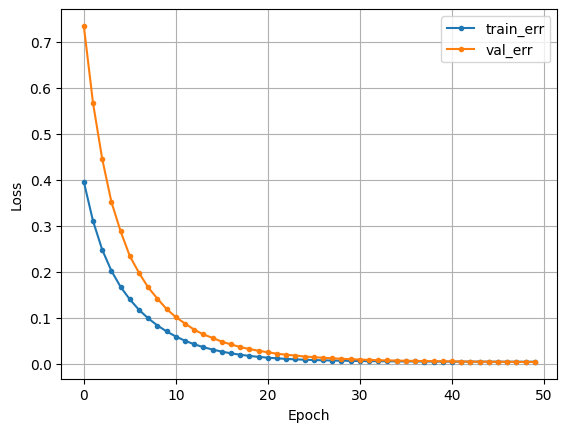

In [32]:
dl_history_plot(history.history)

In [33]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model.predict(x_val_12)
pred = pred * (y_max12 - y_min_12) + y_min_12
y_val2 = y_val_12 * (y_max12 - y_min_12) + y_min_12

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
MAE :  2596.3249393717447
MAPE :  0.21610254130517453
R2 :  -0.1382973669600327


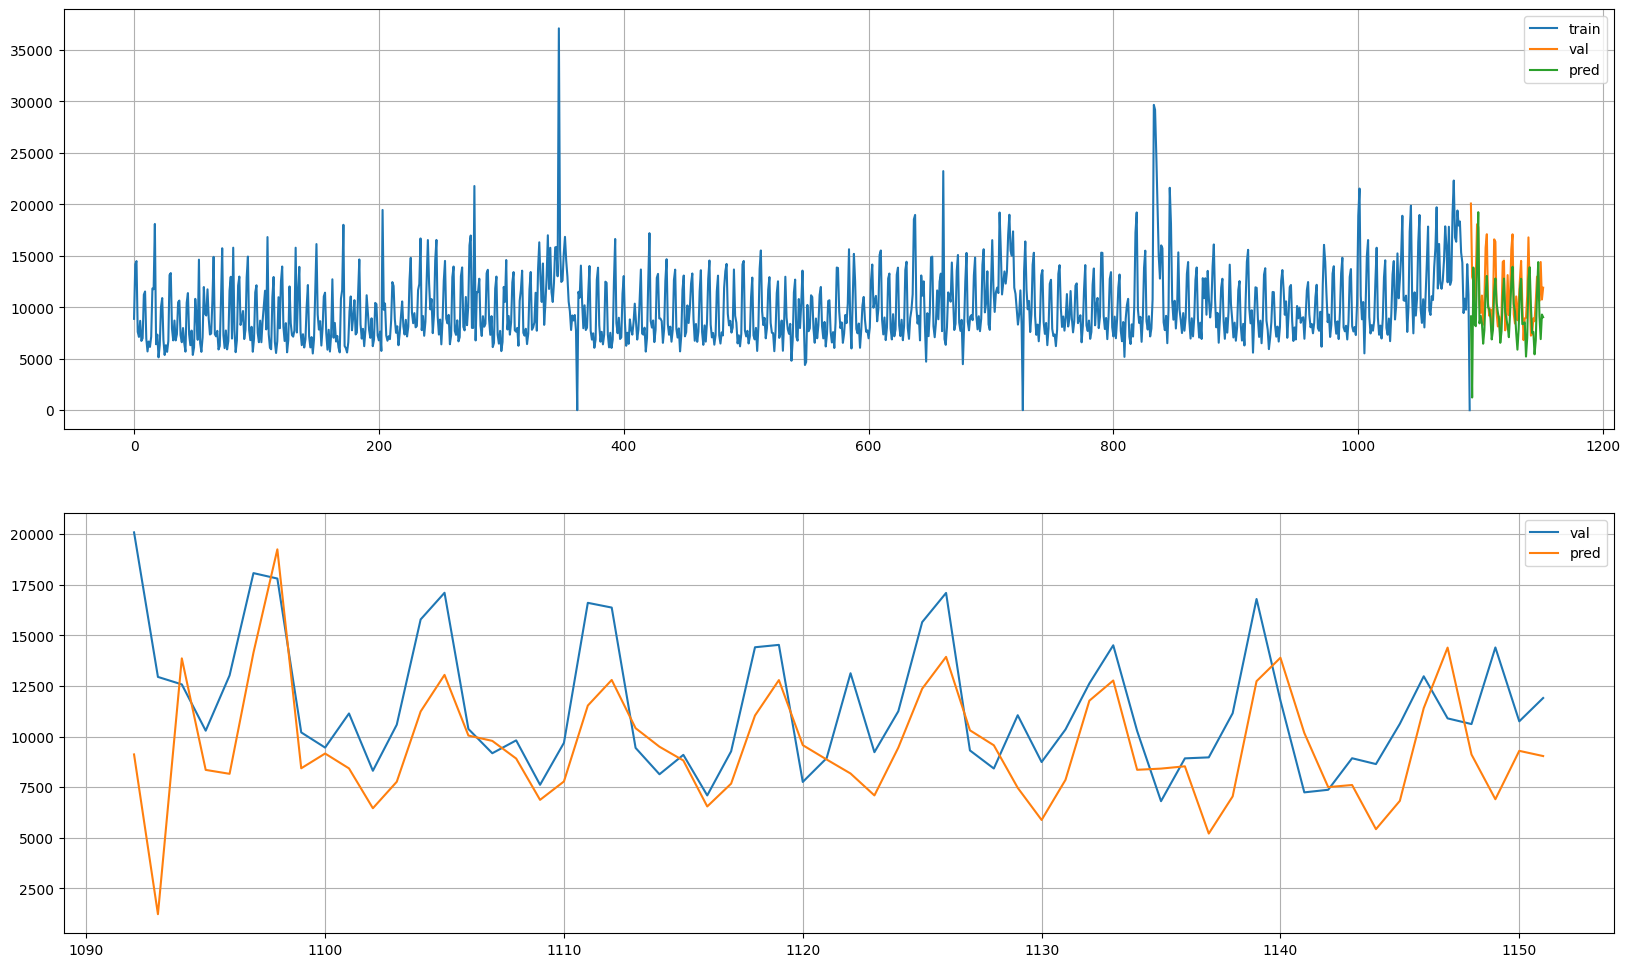

In [34]:
y_train2 = y_train_12 * (y_max12 - y_min_12) + y_min_12
plot_model_result(y_train2, y_val2, pred)

## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [ ]:
merged_42 = pd.get_dummies(merged_42, columns=['DayOfWeek', 'Month'], drop_first=True)

# Define features and target variable
x = merged_42.drop(columns=['Date', 'Qty'])
y = merged_42['Qty']

# Scale features and target
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

# Convert to DataFrame for ease
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

In [ ]:
train_size = len(x_scaled) - 60
X_train, X_val = x_scaled[:train_size], x_scaled[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1085, 20)
(60, 20)
(1085,)
(60,)


### **2) 모델링**

In [ ]:
clear_session()

input_shape = (X_train.shape[1],)

base_model = Sequential([
    Dense(1, input_shape=input_shape)
])


base_model.compile(optimizer='adam', loss='mse')
history = base_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 13865.6445 - val_loss: 7989.1904
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13808.0723 - val_loss: 7948.1816
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13734.9033 - val_loss: 7907.3501
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13742.2637 - val_loss: 7867.1982
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13470.8799 - val_loss: 7826.6001
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13494.9287 - val_loss: 7786.3193
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13735.7598 - val_loss: 7746.5981
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13454.7480 - val_loss: 7706.6294
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13027.4023 - val_loss: 7667.2754
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13295.5615 - val_loss: 7627.7998
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13231.3604 - val_loss: 7588.15

In [ ]:
y_pred = base_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Print evaluation metrics
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mean_absolute_percentage_error(y_val, y_pred))
print("R2 Score:", r2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
RMSE: 85.09229442844398
MAE: 83.74266324043273
MAPE: 0.9480273979512106
R2 Score: -30.482210663049646


# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [35]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [72]:
def preproc3d(data, timesteps, y_scale = False) :
    target = 'target'
    x = data.drop([target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x = pd.get_dummies(x, columns = ['WeekDay','Month', 'Season'])
    col_names = x.columns.tolist()


    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

In [74]:

x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(sales_44_12, 7, True)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1026, 7, 26), (120, 7, 26), (1026,), (120,))

* **모델링**

In [75]:
clear_session()

_, ts, nfeat = x_train.shape

# LSTM 층 추가 (입력 차원: timesteps와 features에 맞춰 설정)
model_Lstm = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])

# 모델 구조 확인
model_Lstm.summary()

# 모델 컴파일 (옵티마이저, 손실 함수 설정)
model_Lstm.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history_Lstm = model_Lstm.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4)                   │             496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 501 (1.96 KB)

 Trainable params: 501 (1.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0360 - val_loss: 0.0140
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192 - val_loss: 0.0140
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0133
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0132
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0116
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0113
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0110
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0100
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0106
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0091
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0093
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_l

In [76]:
pred = model_Lstm.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
MAE :  2383.28849609375
MAPE :  6.105639379582757e+17
R2 :  0.26121714391406714


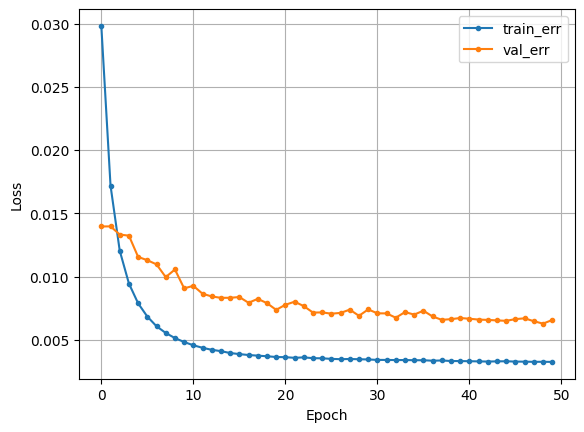

In [77]:
# 성능검증 1 학습곡선
dl_history_plot(history_Lstm.history)

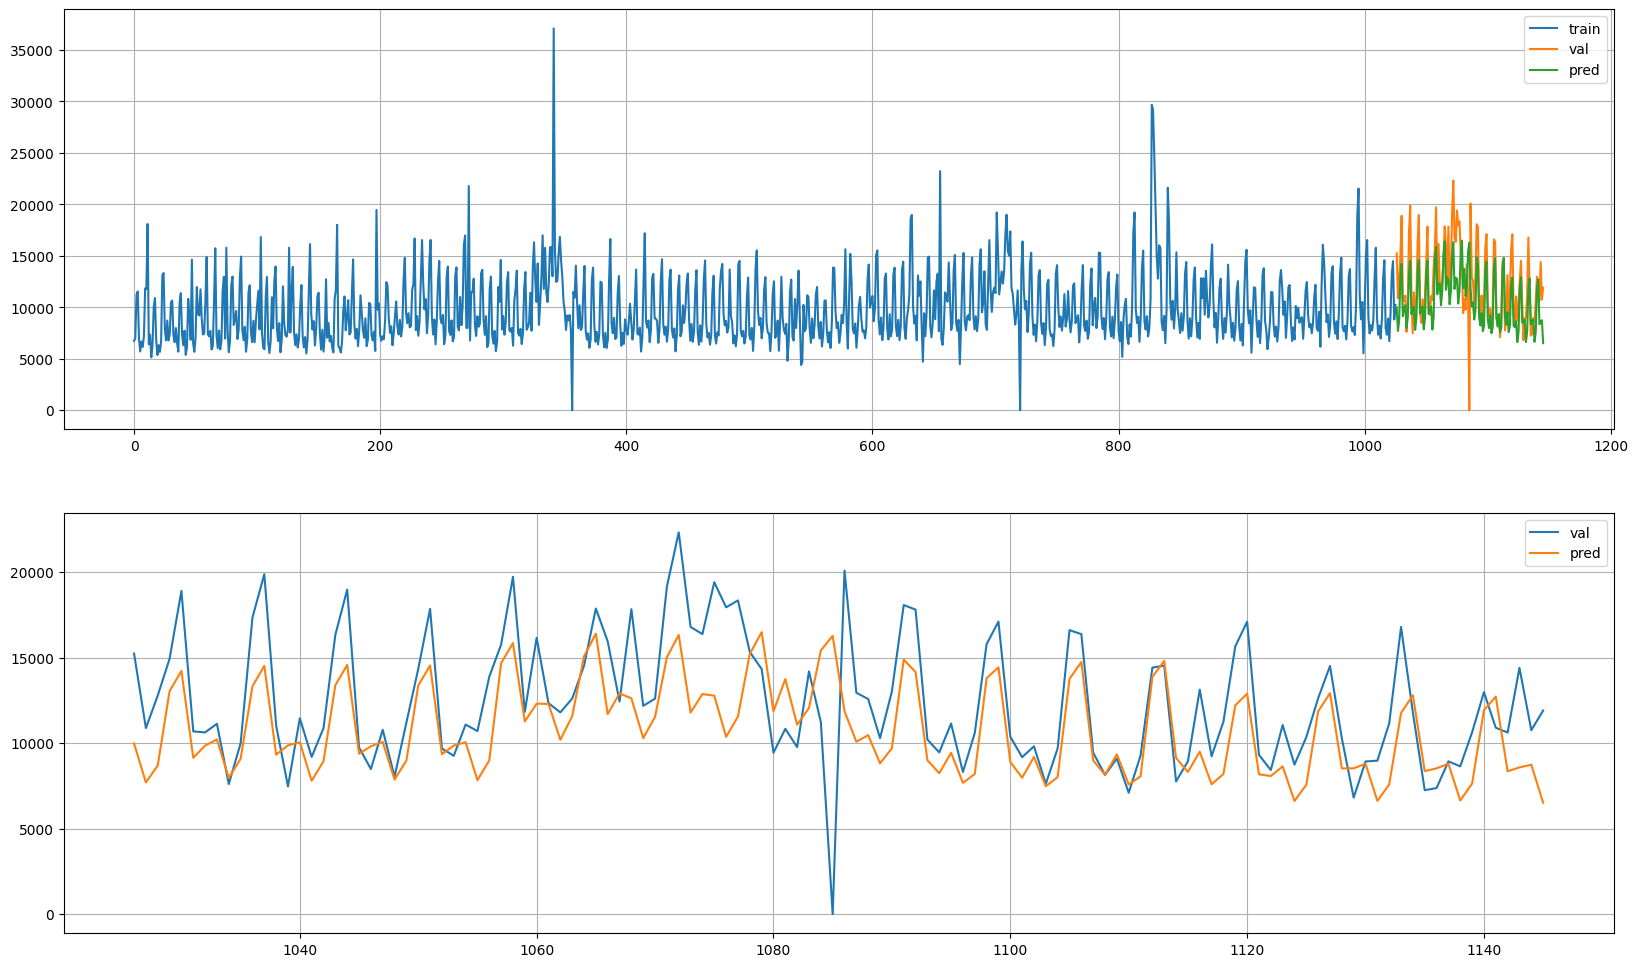

In [78]:
# 성능검증 2 예측결과 시각화
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [39]:
timesteps = 60
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(sales_44_12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 37106.0, (973, 60, 26), (120, 60, 26))

* **모델링**

In [40]:
clear_session()

_, ts, nfeat = x_train.shape

# LSTM 층 추가 (입력 차원: timesteps와 features에 맞춰 설정)
model_Lstm = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])

# 모델 구조 확인
model_Lstm.summary()

# 모델 컴파일 (옵티마이저, 손실 함수 설정)
model_Lstm.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history_Lstm = model_Lstm.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4)                   │             496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 501 (1.96 KB)

 Trainable params: 501 (1.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1917 - val_loss: 0.0431
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0752 - val_loss: 0.0283
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0346 - val_loss: 0.0252
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0209 - val_loss: 0.0250
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0172 - val_loss: 0.0234
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0148 - val_loss: 0.0211
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0121 - val_loss: 0.0197
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0104 - val_loss: 0.0179
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0100 - val_loss: 0.0166
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0090 - val_loss: 0.0152
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0086 - val_loss: 0.0142
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0

In [41]:
pred = model_Lstm.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step
MAE :  2570.2281201171872
MAPE :  6.943787564335629e+17
R2 :  0.1714050290057687


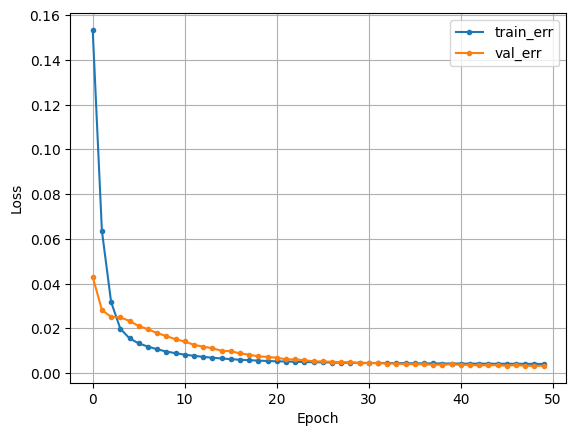

In [42]:
# 성능검증 1 학습곡선
dl_history_plot(history_Lstm.history)

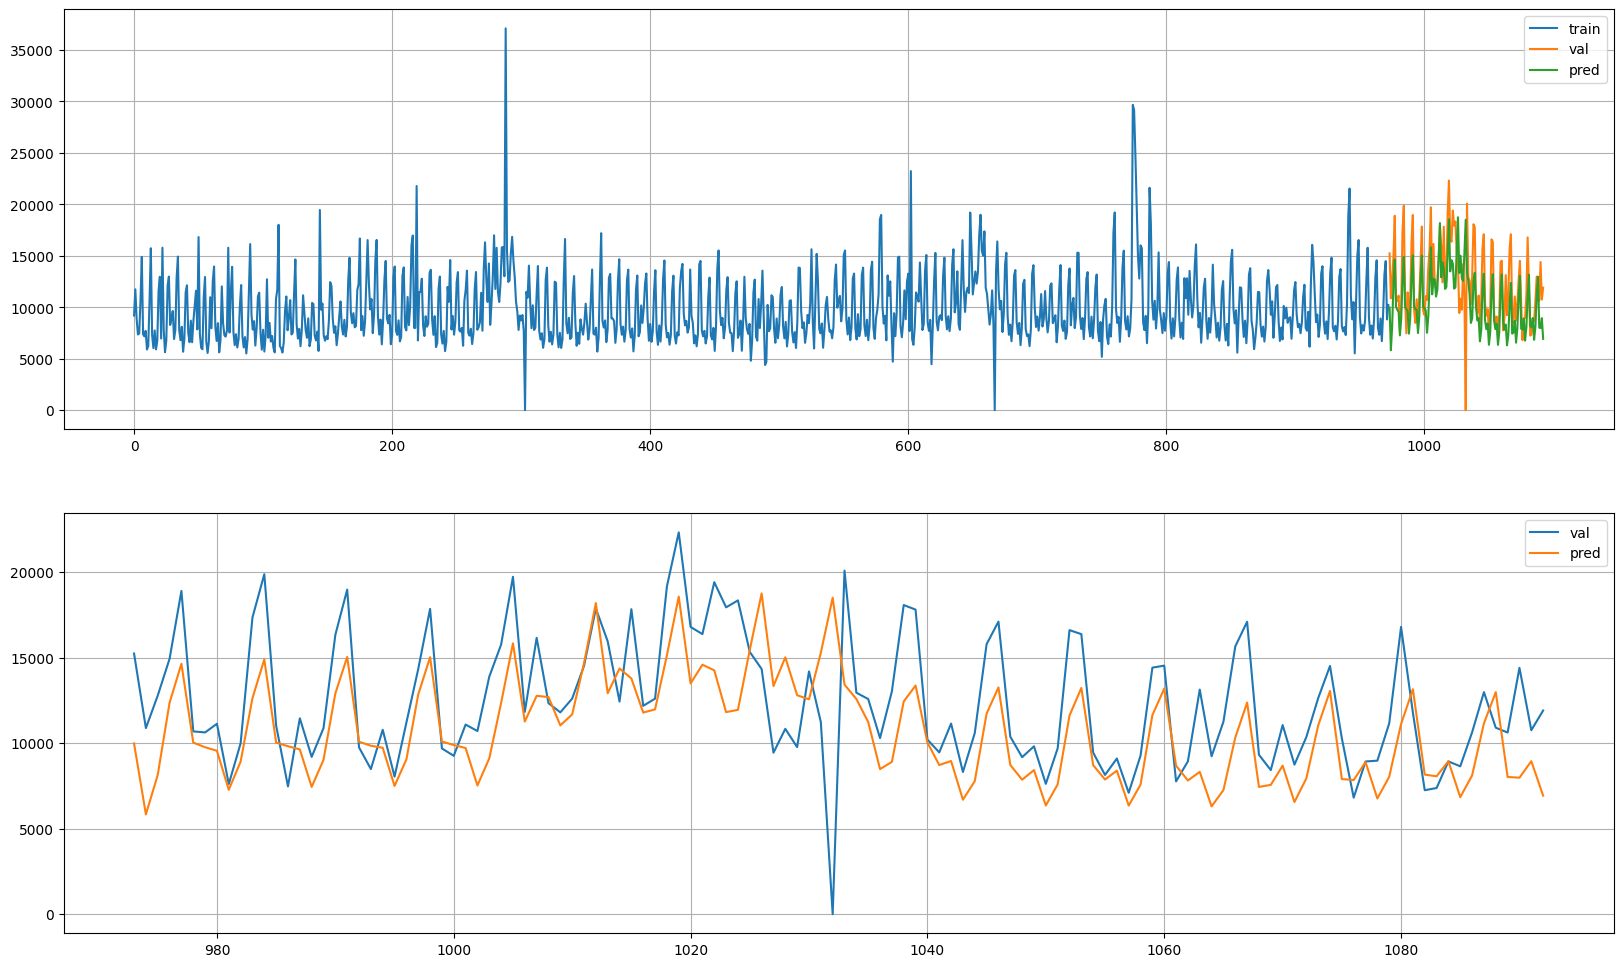

In [43]:
# 성능검증 2 예측결과 시각화
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
timesteps = 7
X_train_seq, y_train_seq = temporalize(X_train, y_train, timesteps)
X_val_seq, y_val_seq = temporalize(X_val, y_val, timesteps)

In [ ]:
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2]) # (samples, timesteps, features) 구성
X_val_seq = X_val_seq.reshape(X_val_seq.shape[0], X_val_seq.shape[1], X_val_seq.shape[2])

* **모델링**

#### LSTM 1

In [ ]:
from keras.layers import Dropout

lstm_model1 = Sequential([
    LSTM(128, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model1.compile(optimizer='adam', loss='mse')

history_lstm1 = lstm_model1.fit(X_train_seq, y_train_seq, epochs=20, batch_size=16, validation_data=(X_val_seq, y_val_seq))

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 12720.9697 - val_loss: 1502.2532
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3284.8567 - val_loss: 550.6303
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1765.6561 - val_loss: 544.3799
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1527.8823 - val_loss: 660.5402
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1579.2904 - val_loss: 617.1403
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1513.8660 - val_loss: 608.2007
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1448.2703 - val_loss: 505.1378
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1487.4991 - val_loss: 627.1113
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1315.4646 - val_loss: 227.3368
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 989.1737 - val_loss: 295.8221
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 886.4819 - val_loss: 211.9747
Epoch 12/20
68/68 

In [ ]:
y_pred_lstm1 = lstm_model1.predict(X_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_seq, y_pred_lstm1))
mae = mean_absolute_error(y_val_seq, y_pred_lstm1)
r2 = r2_score(y_val_seq, y_pred_lstm1)

# Print evaluation metricsprint("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mean_absolute_percentage_error(y_val_seq, y_pred_lstm1))
print("R2 Score:", r2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
MAE: 10.953258796974465
MAPE: 0.11615369194662149
R2 Score: 0.1424788559562692


In [ ]:
df_lstm = pd.DataFrame({'y_pred': y_pred_lstm1.flatten(), 'y_val': y_val_seq})
df_lstm.head(3)

,y_pred,y_val
0,80.746475,100.0
1,86.025887,77.0
2,88.100647,117.0


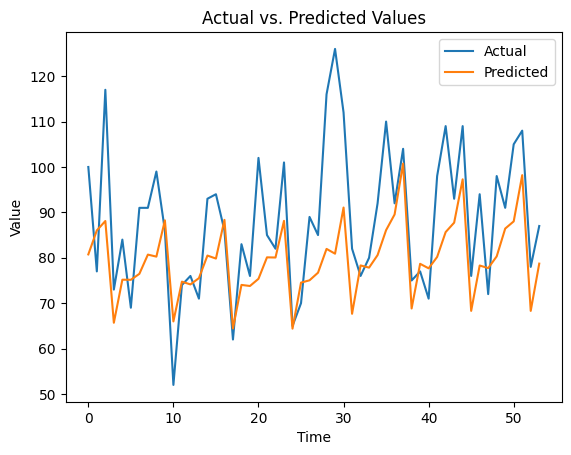

In [ ]:
# Import necessary library for plotting
import matplotlib.pyplot as plt

# Create the line chart
plt.plot(df_lstm.y_val, label='Actual')
plt.plot(df_lstm.y_pred, label='Predicted')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')

# Add legend
plt.legend()

# Display the chart
plt.show()

#### LSTM 2

In [ ]:
from keras.layers import Dropout,Flatten
from keras.callbacks import EarlyStopping

clear_session()

lstm_model2 = Sequential([
    LSTM(128, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
lstm_model2.compile(optimizer='adam', loss='mse')

history_lstm2 = lstm_model2.fit(X_train_seq, y_train_seq,
                               epochs=20,
                               batch_size=16,
                               validation_data=(X_val_seq, y_val_seq),
                               callbacks=[es])

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 12219.7617 - val_loss: 523.1396
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1031.7427 - val_loss: 614.8345
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 840.5093 - val_loss: 213.9644
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 578.5479 - val_loss: 120.4279
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 475.3804 - val_loss: 143.1522
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 493.6386 - val_loss: 121.6161
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 419.4483 - val_loss: 136.1769
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


In [ ]:
y_pred_lstm2 = lstm_model2.predict(X_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_seq, y_pred_lstm2))
mae = mean_absolute_error(y_val_seq, y_pred_lstm2)
r2 = r2_score(y_val_seq, y_pred_lstm2)

print("MAE:", mae)
print("MAPE:", mean_absolute_percentage_error(y_val_seq, y_pred_lstm2))
print("R2 Score:", r2)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
MAE: 8.91795179578993
MAPE: 0.10350505019399502
R2 Score: 0.4878367716051387


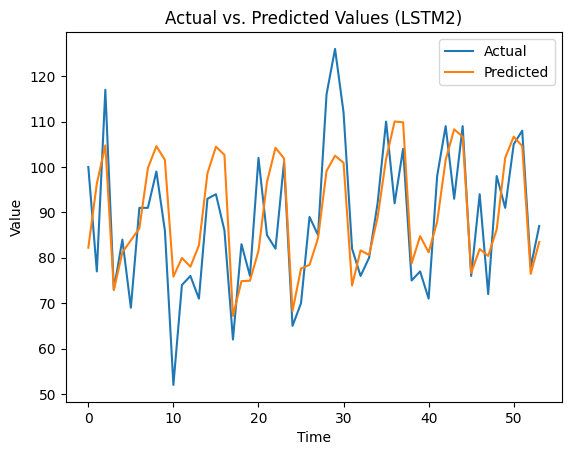

In [ ]:
import matplotlib.pyplot as plt

# Create the line chart
plt.plot(y_val_seq, label='Actual')
plt.plot(y_pred_lstm2.flatten(), label='Predicted')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (LSTM2)')

# Add legend
plt.legend()

# Display the chart
plt.show()

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

#### cnn1

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

cnn_model1 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

cnn_model1.compile(optimizer='adam', loss='mse')

history_cnn1 = cnn_model1.fit(X_train_seq, y_train_seq, epochs=20, batch_size=16, validation_data=(X_val_seq, y_val_seq))

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 12236.7480 - val_loss: 198.7917
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 678.7193 - val_loss: 154.5243
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 394.1789 - val_loss: 106.9231
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 289.4041 - val_loss: 97.2507
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 223.9311 - val_loss: 96.2170
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 209.6890 - val_loss: 97.0320
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 204.3532 - val_loss: 101.1505
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 175.7362 - val_loss: 105.4527
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167.8969 - val_loss: 105.9049
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 161.4315 - val_loss: 108.3253
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 150.0728 - val_loss: 112.2114
Epoch 12/20
68/68 ━━━━━━━━━━━━━

In [ ]:
y_pred_cnn1 = cnn_model1.predict(X_val_seq)

rmse_cnn = np.sqrt(mean_squared_error(y_val_seq, y_pred_cnn1))
mae_cnn = mean_absolute_error(y_val_seq, y_pred_cnn1)
r2_cnn = r2_score(y_val_seq, y_pred_cnn1)

# Print evaluation metrics
print("RMSE:", rmse_cnn)
print("MAE:", mae_cnn)
print("MAPE:", mean_absolute_percentage_error(y_val_seq, y_pred_cnn1))
print("R2 Score:", r2_cnn)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
RMSE: 10.46153430557012
MAE: 8.250529677779586
MAPE: 0.09449660685490725
R2 Score: 0.5345511024805071


In [ ]:
df_cnn = pd.DataFrame({'y_pred': y_pred_cnn1.flatten(), 'y_val': y_val_seq})
df_cnn.head(3)

,y_pred,y_val
0,89.038551,100.0
1,96.068779,77.0
2,106.043121,117.0


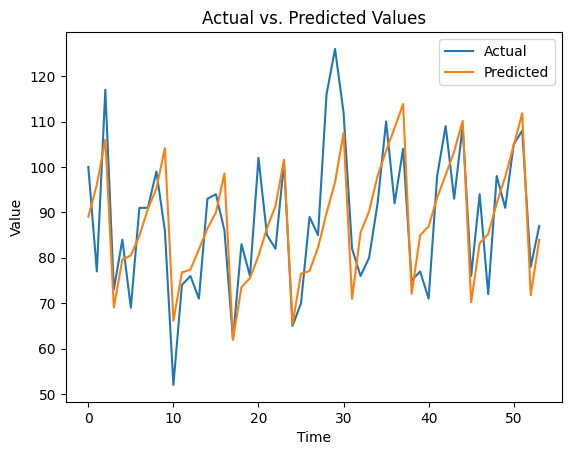

In [ ]:
plt.plot(df_cnn.y_val, label='Actual')
plt.plot(df_cnn.y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

#### cnn2

In [ ]:
cnn_model2 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    MaxPooling1D(pool_size=1),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

cnn_model2.compile(optimizer='adam', loss='mse')

history_cnn2 = cnn_model2.fit(X_train_seq, y_train_seq, epochs=20, batch_size=16, validation_data=(X_val_seq, y_val_seq),callbacks=[es])

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 12508.7334 - val_loss: 769.5447
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 785.3524 - val_loss: 147.7688
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 371.7442 - val_loss: 120.0136
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 272.0629 - val_loss: 113.1187
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 228.8828 - val_loss: 111.9171
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 195.9788 - val_loss: 114.7351
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 197.4347 - val_loss: 115.1410
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 176.0663 - val_loss: 120.6122
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.


In [ ]:
y_pred_cnn2 = cnn_model2.predict(X_val_seq)

rmse_cnn = np.sqrt(mean_squared_error(y_val_seq, y_pred_cnn2))
mae_cnn = mean_absolute_error(y_val_seq, y_pred_cnn2)
r2_cnn = r2_score(y_val_seq, y_pred_cnn2)

# Print evaluation metrics
print("RMSE:", rmse_cnn)
print("MAE:", mae_cnn)
print("MAPE:", mean_absolute_percentage_error(y_val_seq, y_pred_cnn2))
print("R2 Score:", r2_cnn)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
RMSE: 10.579089210110043
MAE: 8.167532956158674
MAPE: 0.09396577270494735
R2 Score: 0.5240319537040425


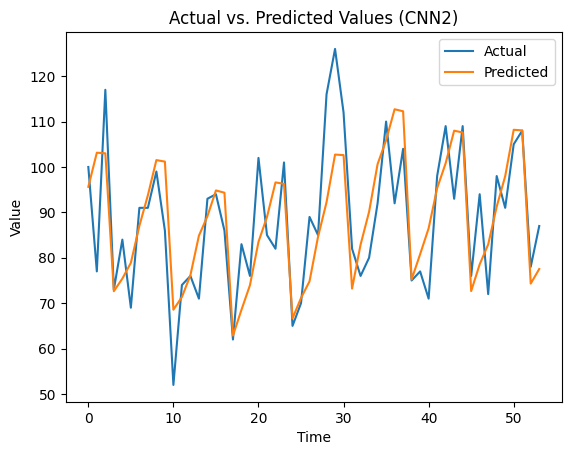

In [ ]:
# cnn2
plt.plot(y_val_seq, label='Actual')
plt.plot(y_pred_cnn2.flatten(), label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (CNN2)')
plt.legend()
plt.show()

In [ ]:
# 큰 경향성만 따라가는 것 같다.

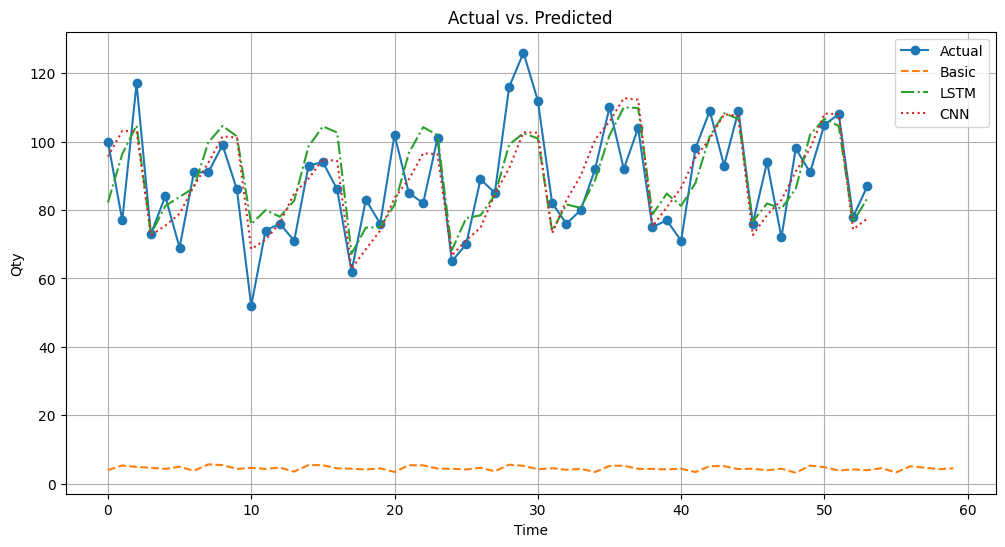

In [ ]:
# 전체 비교
plt.figure(figsize=(12, 6))
plt.plot(y_val_seq, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Basic', linestyle='--')
plt.plot(y_pred_lstm2.flatten(), label='LSTM', linestyle='-.')
plt.plot(y_pred_cnn2.flatten(), label='CNN', linestyle=':')

plt.xlabel('Time')
plt.ylabel('Qty')
plt.title('Actual vs. Predicted')
plt.legend()

plt.grid(True)
plt.show()

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
#42
joblib.dump(merged_42, path + 'sales_42.pkl')
joblib.dump(merged_42_re, path + 'sales_42_re.pkl')

['/content/drive/MyDrive/mp_06/merged_42_re.pkl']

In [96]:
#12
joblib.dump(sales_44_12, 'sales_12.pkl')

['sales_12.pkl']

In [97]:
joblib.dump(df, 'sales_3.pkl')

['sales_3.pkl']